# Libraries

In [109]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import seaborn as sns

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Size and Directory Path

In [111]:
img_width, img_height = 224, 224
num_classes = 10
batch_size = 32
dataset_dir = "/content/drive/My Drive/Dataset_balance"

# Model Building

In [112]:
base_model = ResNet50(weights = 'imagenet', include_top =False, input_shape=(img_width, img_height, 3))

In [113]:
for layer in base_model.layers:
  layer.trainable = False

In [114]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

In [115]:
model = Model(
    inputs=base_model.input, 
    outputs=predictions
    )

In [116]:
model.compile(
    optimizer='adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
    )

In [117]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

# Pre-Process Data using ImageDataGenerator

In [118]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
  )

In [119]:
train_data = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 10040 images belonging to 10 classes.


In [120]:
train_data.class_indices

{'Bacterial_spot': 0,
 'Early_blight': 1,
 'Late_blight': 2,
 'Leaf_Mold': 3,
 'Septoria_leaf_spot': 4,
 'Spider_mites Two-spotted_spider_mite': 5,
 'Target_Spot': 6,
 'Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato_mosaic_virus': 8,
 'healthy': 9}

In [121]:
train_data.image_shape

(224, 224, 3)

In [122]:
val_datagen = ImageDataGenerator(rescale = 1./255)

In [123]:
val_data = val_datagen.flow_from_directory(
    os.path.join(dataset_dir, "val"),
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 1250 images belonging to 10 classes.


# Visualizing Data

<Axes: xlabel='labels', ylabel='count'>

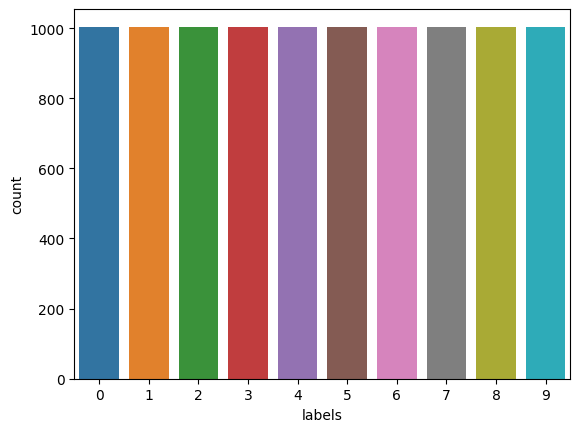

In [124]:
labelDf = pd.DataFrame(train_data.labels)
labelDf.rename(columns = {0:'labels'}, inplace = True)

sns.countplot(data=labelDf, x='labels')

In [125]:
train_data.samples

10040

# Model Checkpoint

In [126]:
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint(filepath= "/content/drive/My Drive/resNet50.h5", 
                     monitor  = "val_accuracy", 
                     verbose = 1, 
                     save_best_only= True)

In [127]:
his = model.fit(
    train_data,
    steps_per_epoch = np.ceil(train_data.samples/batch_size),
    epochs = 40,
    validation_data = val_data,
    callbacks = [mc]
)

Epoch 1/40
314/314 [==============================] - ETA: 0s - loss: 3.3327 - accuracy: 0.2823
Epoch 1: val_accuracy improved from -inf to 0.43600, saving model to /content/drive/My Drive/resNet50.h5
314/314 [==============================] - 70s 212ms/step - loss: 3.3327 - accuracy: 0.2823 - val_loss: 1.5811 - val_accuracy: 0.4360
Epoch 2/40
314/314 [==============================] - ETA: 0s - loss: 1.4757 - accuracy: 0.4827
Epoch 2: val_accuracy improved from 0.43600 to 0.57360, saving model to /content/drive/My Drive/resNet50.h5
314/314 [==============================] - 64s 205ms/step - loss: 1.4757 - accuracy: 0.4827 - val_loss: 1.2713 - val_accuracy: 0.5736
Epoch 3/40
314/314 [==============================] - ETA: 0s - loss: 1.3509 - accuracy: 0.5248
Epoch 3: val_accuracy did not improve from 0.57360
314/314 [==============================] - 56s 177ms/step - loss: 1.3509 - accuracy: 0.5248 - val_loss: 1.2881 - val_accuracy: 0.5352
Epoch 4/40
314/314 [==========================

In [128]:
from tensorflow.keras.models import load_model

In [129]:
model = load_model("/content/drive/My Drive/resNet50.h5")

In [130]:
model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [131]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

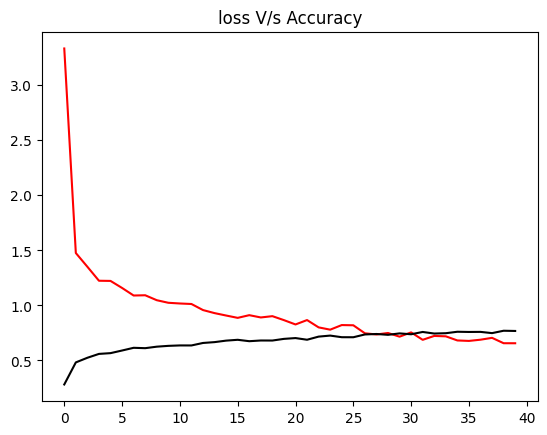

In [134]:
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "k")
plt.title("loss V/s Accuracy")
plt.show()

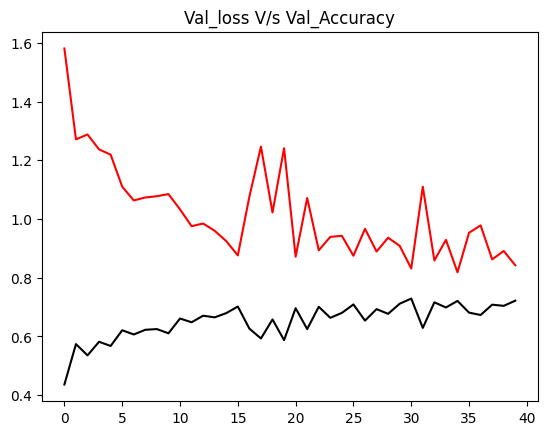

In [133]:
plt.plot(h['val_loss'], "r")
plt.plot(h['val_accuracy'], "k")
plt.title("Val_loss V/s Val_Accuracy")
plt.show()

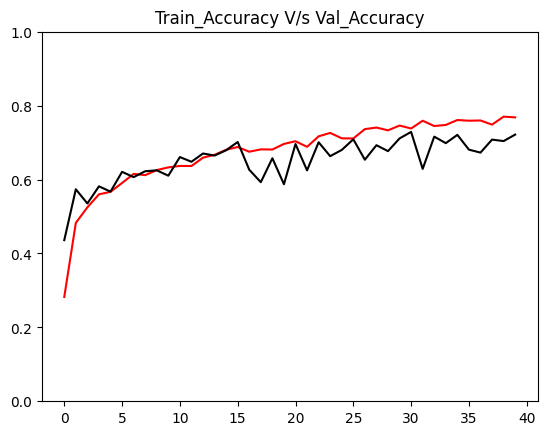

In [135]:
plt.plot(h['accuracy'], "r")
plt.plot(h['val_accuracy'], "k")
plt.ylim((0, 1))
plt.title("Train_Accuracy V/s Val_Accuracy")
plt.show()

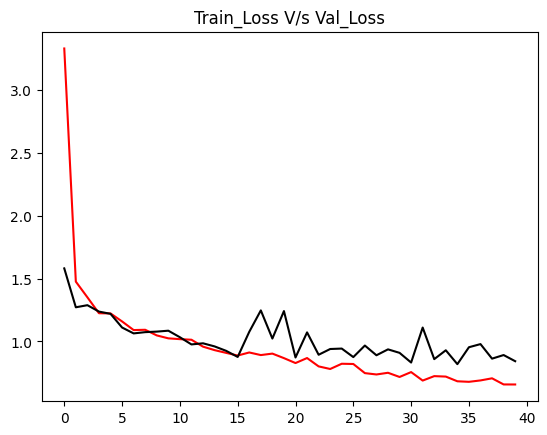

In [136]:
plt.plot(h['loss'], "r")
plt.plot(h['val_loss'], "k")
plt.title("Train_Loss V/s Val_Loss")
plt.show()